In [3]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, RocCurveDisplay
from sklearn.preprocessing import label_binarize
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
import torch

In [5]:
# W&B'yi devre dışı bırak
os.environ["WANDB_DISABLED"] = "true"

# 1. Veri Setini Yükleme ve Ön İşleme
df = pd.read_csv("7allV03.csv")
texts = df['text'].tolist()  # Metin sütunu
labels = df['category'].tolist()  # Etiket sütunu

# Sınıf dengesi kontrolü
print(df['category'].value_counts())

# Etiketleri integer olarak kodlama
unique_labels = list(set(labels))
label_to_int = {label: i for i, label in enumerate(unique_labels)}
int_labels = [label_to_int[label] for label in labels if label in label_to_int]

# 2. Veriyi Eğitim, Doğrulama ve Test Setine Bölme
train_texts, temp_texts, train_labels, temp_labels = train_test_split(texts, int_labels, test_size=0.2, stratify=int_labels)
val_texts, test_texts, val_labels, test_labels = train_test_split(temp_texts, temp_labels, test_size=0.5, stratify=temp_labels)

# 3. Tokenizer Seçimi ve Veriyi Dönüştürme
# Multilingual BERT Tokenizer
multilingual_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-uncased')
# Türkçe BERT Tokenizer
turkish_tokenizer = BertTokenizer.from_pretrained('savasy/bert-turkish-text-classification')

# Tokenize etme
train_encodings_multilingual = multilingual_tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings_multilingual = multilingual_tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings_multilingual = multilingual_tokenizer(test_texts, truncation=True, padding=True, max_length=512)

train_encodings_turkish = turkish_tokenizer(train_texts, truncation=True, padding=True, max_length=512)
val_encodings_turkish = turkish_tokenizer(val_texts, truncation=True, padding=True, max_length=512)
test_encodings_turkish = turkish_tokenizer(test_texts, truncation=True, padding=True, max_length=512)

# Dataset hazırlama
class TextDataset(torch.utils.data.Dataset):
    def __init__(self, encodings, labels):
        self.encodings = encodings
        self.labels = labels

    def __len__(self):
        return len(self.labels)

    def __getitem__(self, idx):
        item = {key: torch.tensor(val[idx]) for key, val in self.encodings.items()}
        item['labels'] = torch.tensor(int(self.labels[idx]), dtype=torch.long)
        return item

train_dataset_multilingual = TextDataset(train_encodings_multilingual, train_labels)
val_dataset_multilingual = TextDataset(val_encodings_multilingual, val_labels)
test_dataset_multilingual = TextDataset(test_encodings_multilingual, test_labels)

train_dataset_turkish = TextDataset(train_encodings_turkish, train_labels)
val_dataset_turkish = TextDataset(val_encodings_turkish, val_labels)
test_dataset_turkish = TextDataset(test_encodings_turkish, test_labels)

# 4. Model Tanımlama ve Eğitim
# Multilingual BERT Modeli
multilingual_model = BertForSequenceClassification.from_pretrained('bert-base-multilingual-uncased', num_labels=len(unique_labels))

# Türkçe BERT Modeli
turkish_model = BertForSequenceClassification.from_pretrained('savasy/bert-turkish-text-classification', num_labels=len(unique_labels))

# Eğitim ayarları
def train_model(model, train_dataset, val_dataset, output_dir):
    training_args = TrainingArguments(
        output_dir=output_dir,
        evaluation_strategy="epoch",
        learning_rate=2e-5,
        per_device_train_batch_size=16,
        per_device_eval_batch_size=16,
        num_train_epochs=3,
        weight_decay=0.01,
        logging_dir='./logs',
        logging_steps=10,
        save_total_limit=1,
        save_steps=500,
        report_to=[]  # W&B'yi devre dışı bırakır
    )

    trainer = Trainer(
        model=model,
        args=training_args,
        train_dataset=train_dataset,
        eval_dataset=val_dataset,
        compute_metrics=lambda p: {
            'accuracy': (p.predictions.argmax(-1) == p.label_ids).mean()
        }
    )

    trainer.train()
    return trainer



category
siyaset       700
dunya         700
ekonomi       700
kultur        700
saglik        700
spor          700
teknoloji     700
Name: count, dtype: int64


model.safetensors:   0%|          | 0.00/672M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-multilingual-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/443M [00:00<?, ?B/s]

In [6]:
# Multilingual Model Eğitimi
trainer_multilingual = train_model(multilingual_model, train_dataset_multilingual, val_dataset_multilingual, "./multilingual_bert")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.352700,0.358740,0.906122
2,0.258900,0.276823,0.922449
3,0.174800,0.276628,0.924490


In [7]:
# Türkçe Model Eğitimi
trainer_turkish = train_model(turkish_model, train_dataset_turkish, val_dataset_turkish, "./turkish_bert")

/usr/local/lib/python3.11/dist-packages/transformers/training_args.py:1575: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(


Epoch,Training Loss,Validation Loss,Accuracy
1,0.098500,0.174488,0.961224
2,0.091500,0.161177,0.967347
3,0.013600,0.167012,0.965306


In [8]:
# 5. Değerlendirme
# Multilingual Model Test Sonuçları
preds_multilingual = trainer_multilingual.predict(test_dataset_multilingual)
pred_labels_multilingual = preds_multilingual.predictions.argmax(-1)

In [9]:
# Türkçe Model Test Sonuçları
preds_turkish = trainer_turkish.predict(test_dataset_turkish)
pred_labels_turkish = preds_turkish.predictions.argmax(-1)

Multilingual BERT
              precision    recall  f1-score   support

           0       0.90      0.90      0.90        70
           1       0.83      0.86      0.85        70
           2       0.89      0.90      0.89        70
           3       0.94      0.93      0.94        70
           4       0.87      0.84      0.86        70
           5       0.94      0.93      0.94        70
           6       0.97      0.99      0.98        70

    accuracy                           0.91       490
   macro avg       0.91      0.91      0.91       490
weighted avg       0.91      0.91      0.91       490



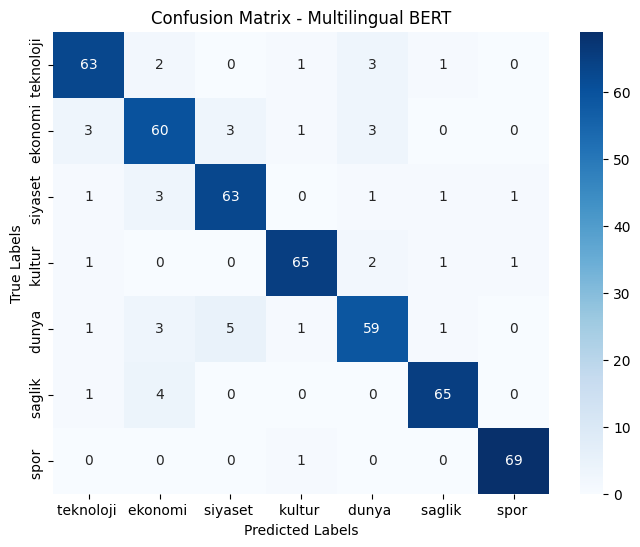


Turkish BERT
              precision    recall  f1-score   support

           0       0.94      0.96      0.95        70
           1       0.93      0.91      0.92        70
           2       0.93      0.97      0.95        70
           3       0.99      1.00      0.99        70
           4       0.96      0.91      0.93        70
           5       0.99      0.97      0.98        70
           6       1.00      1.00      1.00        70

    accuracy                           0.96       490
   macro avg       0.96      0.96      0.96       490
weighted avg       0.96      0.96      0.96       490



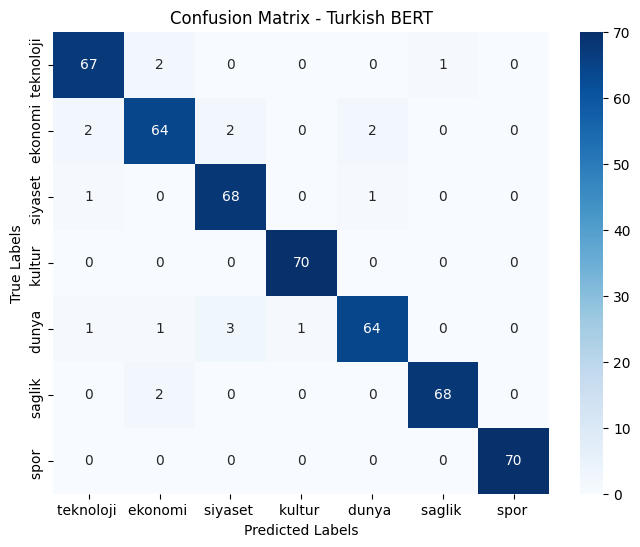

In [10]:
# Confusion Matrix için Renkli Çizim
def plot_confusion_matrix(y_true, y_pred, labels, title):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.title(title)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()

print("Multilingual BERT")
print(classification_report(test_labels, pred_labels_multilingual))
plot_confusion_matrix(test_labels, pred_labels_multilingual, labels=unique_labels, title="Confusion Matrix - Multilingual BERT")

print("\nTurkish BERT")
print(classification_report(test_labels, pred_labels_turkish))
plot_confusion_matrix(test_labels, pred_labels_turkish, labels=unique_labels, title="Confusion Matrix - Turkish BERT")


AUC Multilingual BERT: 0.9912001943634597
AUC Turkish BERT: 0.9971720116618076


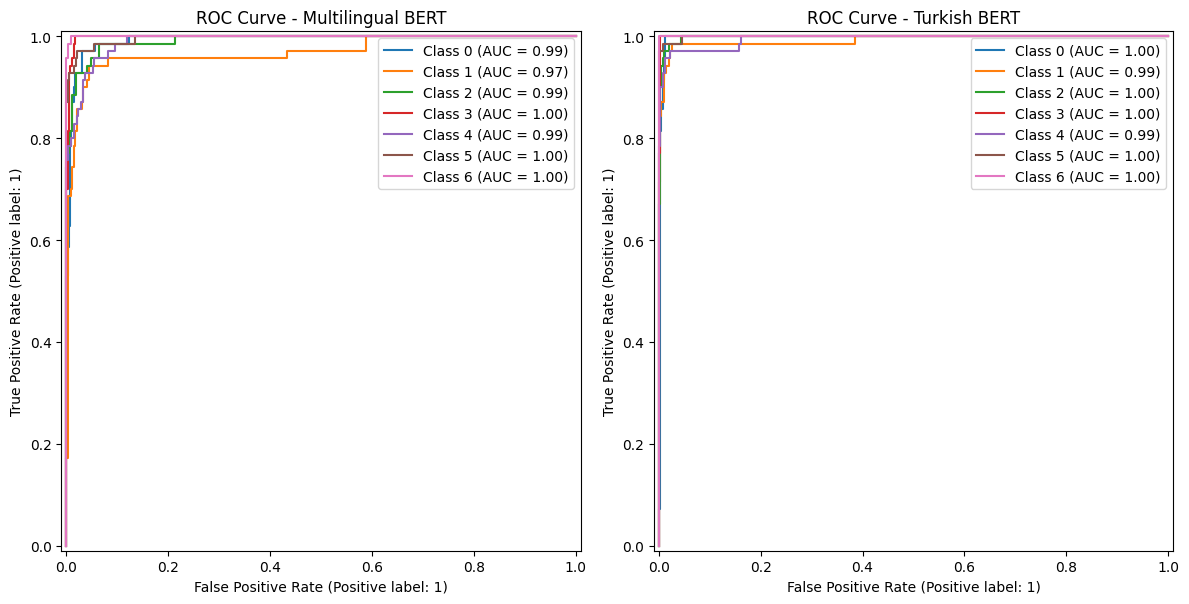

In [11]:
# AUC hesaplama için test etiketlerini binary formata dönüştür
num_classes = len(unique_labels)
test_labels_binarized = label_binarize(test_labels, classes=list(range(num_classes)))

# AUC hesaplama (Multilingual)
auc_multilingual = roc_auc_score(test_labels_binarized, preds_multilingual.predictions, multi_class='ovr', average='macro')

# AUC hesaplama (Turkish)
auc_turkish = roc_auc_score(test_labels_binarized, preds_turkish.predictions, multi_class='ovr', average='macro')

print(f"AUC Multilingual BERT: {auc_multilingual}")
print(f"AUC Turkish BERT: {auc_turkish}")

# ROC Curve Çizimi
fig, ax = plt.subplots(1, 2, figsize=(12, 6))

for i in range(num_classes):
    RocCurveDisplay.from_predictions(
        test_labels_binarized[:, i], preds_multilingual.predictions[:, i], name=f"Class {i}", ax=ax[0]
    )
ax[0].set_title("ROC Curve - Multilingual BERT")
ax[0].legend(loc="best")

for i in range(num_classes):
    RocCurveDisplay.from_predictions(
        test_labels_binarized[:, i], preds_turkish.predictions[:, i], name=f"Class {i}", ax=ax[1]
    )
ax[1].set_title("ROC Curve - Turkish BERT")
ax[1].legend(loc="best")

plt.tight_layout()
plt.show()